In [614]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import xgboost as xgb
from sklearn.metrics import plot_confusion_matrix

In [615]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q,globals())

In [616]:
df = pd.read_csv('../../data/test/H103.csv', parse_dates=['utc_time'])
df.columns = ['time','batch','phase', 'heat_time', 'weight', 'head_temp', 'head_pressure', 'vac_temp']

In [617]:
df = df[df['phase'].str.contains ('DRYING|DISCHRG|HEATING') == True]
# df = df[df['phase'].str.contains ('DRYING') == True]


In [618]:
df["time"] = df["time"].dt.tz_localize(None)
df['date'] = df['time'].dt.date
df['day'] = df['time'].dt.dayofweek


In [619]:
df.replace({'??????': None}, inplace=True)
df.replace({'????????': None}, inplace=True)
df.dropna(inplace=True)

In [620]:
df['head_temp'] = df.head_temp.astype(float)
df['weight'] = df.weight.astype(float)
df['head_pressure'] = df.head_pressure.astype(float)
df['heat_time'] = df.heat_time.astype(float)
df['vac_temp'] = df.vac_temp.astype(float)
df['batch'] = df.batch.astype(float)
df['phase'] = df.phase.astype('category')

In [621]:
n = 30  # number of points to be checked before and after

# Find local peaks
df['max_temp'] = 0
df['max_temp'] = df.iloc[argrelextrema(df.head_temp.values, np.greater_equal, order=n)]['head_temp']
df.tail(220)

,time,batch,phase,heat_time,weight,head_temp,head_pressure,vac_temp,date,day,max_temp
42850,2022-05-03 06:11:16,148217.0,HEATING,553.0,3103.0,50.8,221.3,25.8,2022-05-03,1,NaN
42851,2022-05-03 06:12:16,148217.0,HEATING,622.7,3122.0,51.0,227.7,25.0,2022-05-03,1,NaN
42852,2022-05-03 06:13:16,148217.0,HEATING,682.5,3156.0,51.1,235.2,25.0,2022-05-03,1,NaN
42853,2022-05-03 06:14:16,148217.0,HEATING,742.4,3174.0,51.3,227.9,24.9,2022-05-03,1,NaN
42854,2022-05-03 06:15:16,148217.0,HEATING,802.2,3180.0,51.5,230.5,24.0,2022-05-03,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
43065,2022-05-03 09:46:16,148217.0,HEATING,5400.0,3331.0,40.6,313.7,20.0,2022-05-03,1,40.6
43066,2022-05-03 09:47:16,148217.0,HEATING,5400.0,3334.0,40.6,317.4,20.0,2022-05-03,1,40.6
43067,2022-05-03 09:48:16,148217.0,HEATING,5400.0,3335.0,40.6,314.7,20.0,2022-05-03,1,40.6
43068,2022-05-03 09:49:16,148217.0,HEATING,5400.0,3346.0,40.6,324.7,21.0,2022-05-03,1,40.6


In [622]:
df['ready'] = 0
delta_t = 2
for i in range (1, len(df['ready']-1)):
    if df.max_temp.values[i] > 0:
        local_max = df.max_temp.values[i]
        current = df.batch.values[i]
        while df['batch'].values[i] == current and i < len(df['ready']-1):
            if local_max - df.head_temp.values[i] > delta_t:
                df.ready.values[i] = 1
            else:
                df.ready.values[i] = 2
            i += 1
            
                
df = df.drop(['max_temp'], axis=1)
df = df[df['phase'].str.contains ('DRYING|HEATING') == True]

IndexError: index 13179 is out of bounds for axis 0 with size 13179

In [ ]:
df['head_pressure_20'] = df['head_pressure'].shift(-20)
df['head_temp_20'] = df['head_temp'].shift(-20)
df['weight_20'] = df['weight'].shift(-20)
df['heat_time_20'] = df['heat_time'].shift(-20)
df['vac_temp_20'] = df['vac_temp'].shift(-20)

df['head_pressure_30'] = df['head_pressure'].shift(-30)
df['head_temp_30'] = df['head_temp'].shift(-30)
df['weight_30'] = df['weight'].shift(-30)
df['heat_time_30'] = df['heat_time'].shift(-30)
df['vac_temp_30'] = df['vac_temp'].shift(-30)

df['head_pressure_35'] = df['head_pressure'].shift(-35)
df['head_temp_35'] = df['head_temp'].shift(-35)
df['weight_35'] = df['weight'].shift(-35)
df['heat_time_35'] = df['heat_time'].shift(-35)
df['vac_temp_35'] = df['vac_temp'].shift(-35)

df['head_pressure_40'] = df['head_pressure'].shift(-40)
df['head_temp_40'] = df['head_temp'].shift(-40)
df['weight_40'] = df['weight'].shift(-40)
df['heat_time_40'] = df['heat_time'].shift(-40)
df['vac_temp_40'] = df['vac_temp'].shift(-40)
df.dropna(inplace=True)
df


,time,batch,phase,heat_time,weight,head_temp,head_pressure,vac_temp,date,day,...,head_pressure_35,head_temp_35,weight_35,heat_time_35,vac_temp_35,head_pressure_40,head_temp_40,weight_40,heat_time_40,vac_temp_40
58,2022-04-03 11:39:13,24683.0,DRYING,2.0,3374.4,57.6,502.1,21.04,2022-04-03,6,...,505.3,61.1,3373.5,21.2,21.18,548.6,61.1,3373.9,21.2,21.17
59,2022-04-03 11:40:13,24683.0,DRYING,3.0,3376.8,56.9,503.2,21.18,2022-04-03,6,...,507.5,61.1,3372.8,21.2,21.16,536.4,61.1,3377.2,21.2,21.19
60,2022-04-03 11:41:13,24683.0,DRYING,4.0,3369.2,56.8,508.8,21.24,2022-04-03,6,...,514.5,61.1,3374.8,21.2,21.16,487.2,61.1,3377.9,21.2,21.19
61,2022-04-03 11:42:13,24683.0,DRYING,5.0,3371.1,57.1,512.7,21.26,2022-04-03,6,...,527.8,61.1,3376.7,21.2,21.17,489.1,61.1,3377.7,21.2,21.18
62,2022-04-03 11:43:13,24683.0,DRYING,6.0,3370.2,57.5,521.9,21.28,2022-04-03,6,...,533.4,61.1,3375.6,21.2,21.17,493.7,61.1,3383.3,21.2,21.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42745,2022-05-03 03:06:13,24781.0,DRYING,46.4,3491.5,43.5,460.7,28.98,2022-05-03,1,...,548.0,47.3,3469.7,0.0,25.16,761.4,42.3,3489.9,0.0,25.13
42746,2022-05-03 03:07:13,24781.0,DRYING,47.4,3490.1,43.0,464.8,28.82,2022-05-03,1,...,725.7,46.8,3499.2,0.0,25.04,761.0,41.3,3488.8,0.0,25.96
42747,2022-05-03 03:08:13,24781.0,DRYING,48.4,3485.9,42.5,468.9,28.68,2022-05-03,1,...,761.5,45.7,3498.0,0.0,24.83,760.8,40.4,3485.7,0.0,26.30
42748,2022-05-03 03:09:13,24781.0,DRYING,49.4,3487.7,42.2,475.2,28.57,2022-05-03,1,...,761.6,44.6,3495.2,0.0,24.64,760.5,39.5,3473.8,0.0,26.36


In [ ]:
# def load_query(path):
#     with open(path) as file:
#         return file.read()

In [ ]:
# query = load_query('queries/daily_cycles.sql')
# daily_cycles = pysqldf(query)

In [ ]:
# daily_cycles.sample(4)

In [ ]:
# daily_cycles.describe()

In [ ]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

In [ ]:
# plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi': 300})
# fig, ax = plt.subplots()
# sns.lineplot(data=daily_cycles.tail(50), x='DATE', y='num_cycles')
# plt.grid(linestyle='-', linewidth=0.3)
# ax.tick_params(axis='x', rotation=90)

In [ ]:
# query = load_query('queries/weekly_cycles.sql')
# weekly_cycles = pysqldf(query)

In [ ]:
# weekly_cycles.tail()

In [ ]:
# plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi': 300})
# fig, ax = plt.subplots()
# sns.lineplot(data=weekly_cycles.tail(50), x='week', y='num_cycles')
# plt.grid(linestyle='-', linewidth=0.3)
# ax.tick_params(axis='x', rotation=90)

In [ ]:
df = df[df['ready'] < 2]

In [ ]:
features = [
            # 'heat_time', 'weight', 'head_temp', 'head_pressure', 'vac_temp',
            # 'heat_time_20', 'weight_20', 'head_temp_20', 'head_pressure_20', 'vac_temp_20',
            # 'heat_time_30', 'weight_30', 'head_temp_30', 'head_pressure_30', 'vac_temp_30',
            'heat_time_35', 'weight_35', 'head_temp_35', 'head_pressure_35', 'vac_temp_35',
            'heat_time_40', 'weight_40', 'head_temp_40', 'head_pressure_40', 'vac_temp_40'
            ]
label = ['ready']
train_df = df.head(int(df.shape[0]*.75))
test_df = df.tail(int(df.shape[0]*0.25))


X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]


In [ ]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            # gamma=0.25,
                            max_depth=8,
                            seed=42)

In [ ]:
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_train, y_train),(X_test, y_test)])

[0]	validation_0-aucpr:0.99768	validation_1-aucpr:0.95493
[1]	validation_0-aucpr:0.99856	validation_1-aucpr:0.95542
[2]	validation_0-aucpr:0.99987	validation_1-aucpr:0.98637
[3]	validation_0-aucpr:0.99989	validation_1-aucpr:0.98638
[4]	validation_0-aucpr:0.99998	validation_1-aucpr:0.98558


C:\Users\lbushman\.virtualenvs\drayers-ZSJxV8Z-\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lbushman\.virtualenvs\drayers-ZSJxV8Z-\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lbushman\.virtualenvs\drayers-ZSJxV8Z-\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

[5]	validation_0-aucpr:0.99999	validation_1-aucpr:0.98532
[6]	validation_0-aucpr:0.99999	validation_1-aucpr:0.98777
[7]	validation_0-aucpr:1.00000	validation_1-aucpr:0.98859
[8]	validation_0-aucpr:1.00000	validation_1-aucpr:0.99069
[9]	validation_0-aucpr:1.00000	validation_1-aucpr:0.99103
[10]	validation_0-aucpr:1.00000	validation_1-aucpr:0.99098
[11]	validation_0-aucpr:1.00000	validation_1-aucpr:0.99029
[12]	validation_0-aucpr:1.00000	validation_1-aucpr:0.98998
[13]	validation_0-aucpr:1.00000	validation_1-aucpr:0.98962
[14]	validation_0-aucpr:1.00000	validation_1-aucpr:0.98955
[15]	validation_0-aucpr:1.00000	validation_1-aucpr:0.98935
[16]	validation_0-aucpr:1.00000	validation_1-aucpr:0.98934
[17]	validation_0-aucpr:1.00000	validation_1-aucpr:0.98944
[18]	validation_0-aucpr:1.00000	validation_1-aucpr:0.98973


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

<AxesSubplot:>

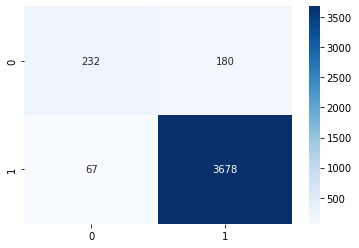

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = clf_xgb.predict_proba(X_test)[:,1]
thr=0.7
sns.heatmap(confusion_matrix(y_test,pred>thr),annot=True,fmt='', cmap='Blues')

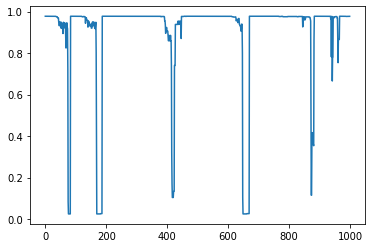

In [ ]:
plt.plot(pd.Series(pred[-1000:]))

C:\Users\lbushman\.virtualenvs\drayers-ZSJxV8Z-\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lbushman\.virtualenvs\drayers-ZSJxV8Z-\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


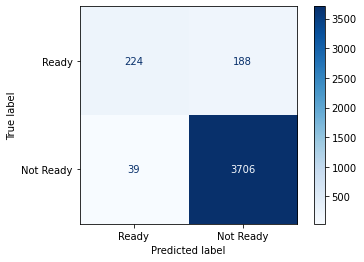

In [ ]:
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      cmap='Blues',
                      display_labels=['Ready', 'Not Ready'])

In [ ]:
bst = clf_xgb.get_booster()
for importance_type in ('weight','gain', 'cover', 'total_gain','total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

weight:  {'heat_time_35': 166.0, 'weight_35': 112.0, 'head_temp_35': 98.0, 'head_pressure_35': 47.0, 'vac_temp_35': 109.0, 'heat_time_40': 66.0, 'weight_40': 90.0, 'head_temp_40': 60.0, 'head_pressure_40': 43.0, 'vac_temp_40': 76.0}
gain:  {'heat_time_35': 24.37181282043457, 'weight_35': 15.641122817993164, 'head_temp_35': 16.76522445678711, 'head_pressure_35': 4.9731245040893555, 'vac_temp_35': 5.527787685394287, 'heat_time_40': 18.74306869506836, 'weight_40': 6.882120132446289, 'head_temp_40': 2.819047689437866, 'head_pressure_40': 2.9372811317443848, 'vac_temp_40': 10.170323371887207}
cover:  {'heat_time_35': 67.55308532714844, 'weight_35': 243.2625732421875, 'head_temp_35': 263.6531066894531, 'head_pressure_35': 46.099178314208984, 'vac_temp_35': 29.056045532226562, 'heat_time_40': 69.02651977539062, 'weight_40': 53.05203628540039, 'head_temp_40': 69.66654968261719, 'head_pressure_40': 31.348400115966797, 'vac_temp_40': 29.90410804748535}
total_gain:  {'heat_time_35': 4045.72094726

In [ ]:
 from sklearn.metrics import accuracy_score

accuracy_score(y_true=y_test, y_pred=clf_xgb.predict_proba(X_test)[:,1]>0.5, normalize=True)

C:\Users\lbushman\.virtualenvs\drayers-ZSJxV8Z-\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.9453933124849652

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=clf_xgb.predict_proba(X_test)[:,1]>0.5, target_names=['ready', 'not yet']))

              precision    recall  f1-score   support

       ready       0.85      0.54      0.66       412
     not yet       0.95      0.99      0.97      3745

    accuracy                           0.95      4157
   macro avg       0.90      0.77      0.82      4157
weighted avg       0.94      0.95      0.94      4157



C:\Users\lbushman\.virtualenvs\drayers-ZSJxV8Z-\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [ ]:
node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}
xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH